In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import cv2

from IPython import display
plt.ion()

# if gpu is to be used
device = torch.device("cpu")

In [3]:
matplotlib.rcParams.update({'font.size': 22})

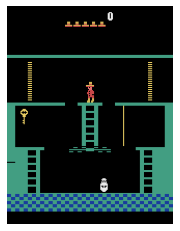

In [5]:
env = gym.make("MontezumaRevenge-v0")
env.reset()


plt.imshow(env.ale.getScreenRGB2())
plt.axis("off")
plt.show()

In [4]:
def plot_norms(episodes):
    plt.figure(2, figsize=(10,10))
    
    plt.title('Action Prediction $\mu$ and $\pm \sigma$ interval')
    plt.xlabel('L2 Norm of Noise')
    plt.ylabel('Average Reward')
    
    for ep, color, label in episodes:
        x, ys = np.array(list(ep.keys())).astype(np.float), np.array(list(ep.values()))
        
        # normalise to the highest reward
        # y = np.mean(ep[0]) for normalising against the first data point
        #y = np.max([np.mean(ep[k]) for k in ep.keys()])
        #ys = (ys - y) / y
        
        mu = np.mean(ys, axis=1)
        plt.plot(x, mu, label=label, color=color, marker='x')
        stds = np.std(ys, axis = 1)
        #plt.fill_between(x, mu + np.max(ys, axis=1) , mu - np.min(ys, axis=1), alpha=0.2, color=color)
        plt.fill_between(x, mu + stds , mu - stds, alpha=0.2, color=color)
    
    plt.legend(prop={'size': 14})
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('noise_sigma.pdf', format='pdf', dpi=1000)

def plot_fgsm(episode_durations):
    plt.figure(2, figsize=(10,10))
    
    plt.title('Action Prediction $\mu$ and $\pm \sigma$ interval')
    for kk in ['both', 'goal_only', 'action_only']:
        x, ys = np.array(list(episode_durations[kk].keys())), np.array(list(episode_durations[kk].values()))
        plt.xlabel('$\epsilon$')
        plt.ylabel('Average Reward')
        
        mu = np.mean(ys, axis=1)
        plt.plot(x, mu, label=kk, marker='x')
        stds = np.std(ys, axis = 1)
        plt.fill_between(x, mu + stds , mu - stds, alpha=0.2)
    
    plt.xticks(rotation=-45)
    plt.legend(prop={'size': 14})
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('fgsm_sigma.pdf', format='pdf', dpi=1000)

In [5]:
def plot_norms_minmax(episodes):
    plt.figure(2, figsize=(10,10))
    
    plt.title('Action Prediction $\mu$ and $min/max$ interval')
    plt.xlabel('L2 Norm of Noise')
    plt.ylabel('Average Reward')
    
    for ep, color, label in episodes:
        x, ys = np.array(list(ep.keys())).astype(np.float), np.array(list(ep.values()))
        
        # normalise to the highest reward
        # y = np.mean(ep[0]) for normalising against the first data point
        #y = np.max([np.mean(ep[k]) for k in ep.keys()])
        #ys = (ys - y) / y
        
        mu = np.mean(ys, axis=1)
        plt.plot(x, mu, label=label, color=color, marker='x')
        stds = np.std(ys, axis = 1)
        plt.fill_between(x, np.max(ys, axis=1) , np.min(ys, axis=1), alpha=0.2, color=color)
    
    plt.legend(prop={'size': 14})
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('noise_minmax.pdf', format='pdf', dpi=1000)

def plot_fgsm_minmax(episode_durations):
    plt.figure(2, figsize=(10,10))
    
    plt.title('Action Prediction $\mu$ and $\pm \sigma$ interval')
    for kk in ['both', 'goal_only', 'action_only']:
        x, ys = np.array(list(episode_durations[kk].keys())), np.array(list(episode_durations[kk].values()))
        plt.xlabel('$\epsilon$')
        plt.ylabel('Average Reward')
        
        mu = np.mean(ys, axis=1)
        plt.plot(x, mu, label=kk, marker='x')
        stds = np.std(ys, axis = 1)
        plt.fill_between(x, np.max(ys, axis=1) , np.min(ys, axis=1), alpha=0.2, color=color)
    
    plt.xticks(rotation=-45)

    plt.legend(prop={'size': 14})
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('fgsm_minmax.pdf', format='pdf', dpi=1000)

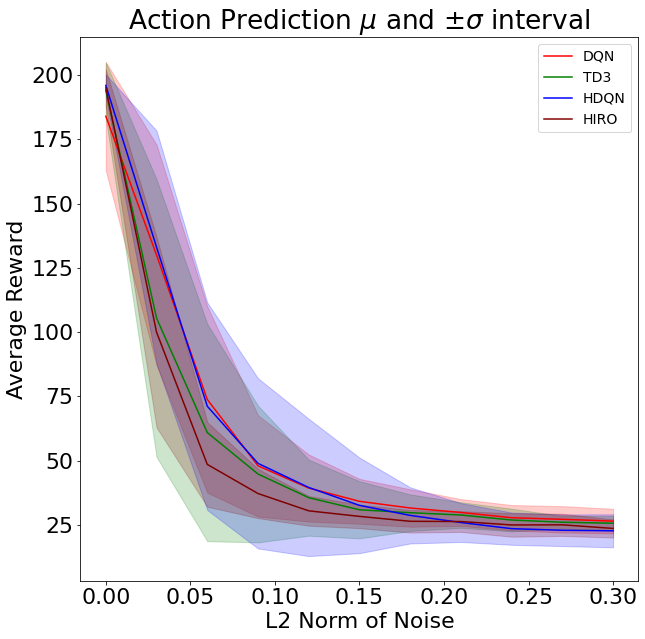

In [6]:
import json
plot_norms([\
    (json.load(open("absolute_noise/dqn_episodes.json")), "red", "DQN"),\
    (json.load(open("absolute_noise/td3_episodes.json")), "green", "TD3"),\
    (json.load(open("absolute_noise/hdqn_episodes.json")), "blue", "HDQN"),\
    (json.load(open("absolute_noise/hiro_episodes.json")), "maroon", "HIRO"),\
   ])

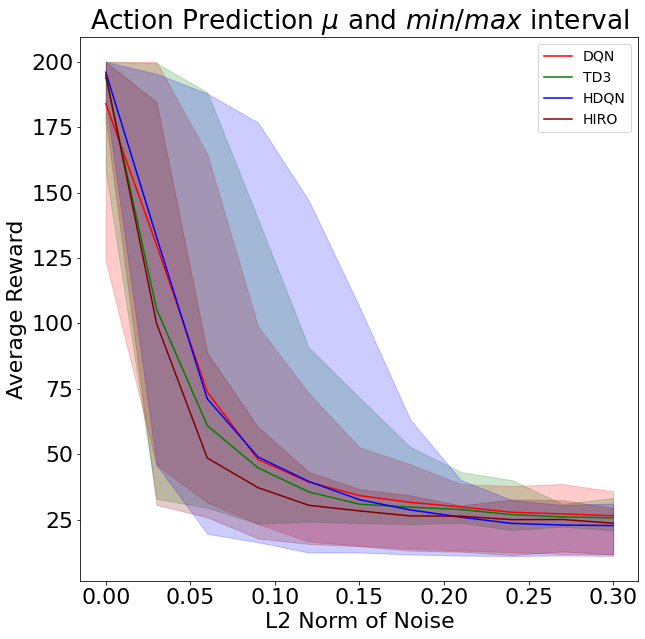

In [7]:
import json
plot_norms_minmax([\
    (json.load(open("absolute_noise/dqn_episodes.json")), "red", "DQN"),\
    (json.load(open("absolute_noise/td3_episodes.json")), "green", "TD3"),\
    (json.load(open("absolute_noise/hdqn_episodes.json")), "blue", "HDQN"),\
    (json.load(open("absolute_noise/hiro_episodes.json")), "maroon", "HIRO"),\
   ])

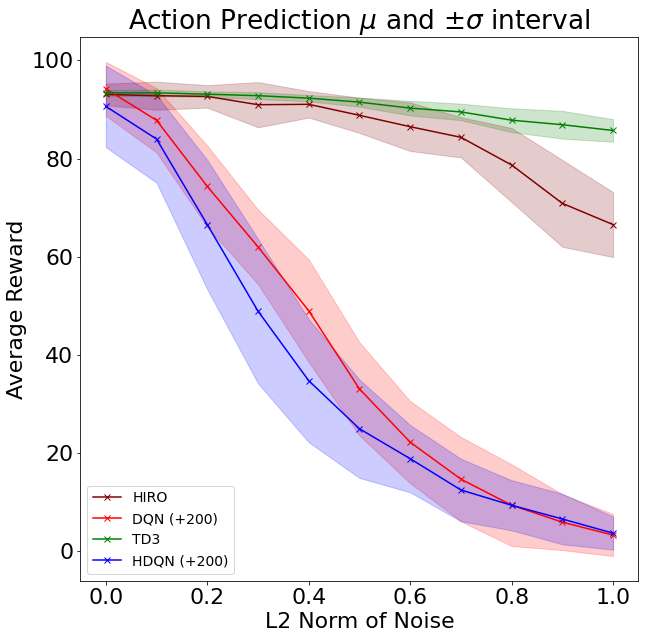

In [13]:
import json
dqn = json.load(open("car/noise/dqn_episodes.json"))
for i in dqn.keys():
    for ii in range(len(dqn[i])):
        dqn[i][ii] += 200

hdqn = json.load(open("car/noise/hdqn_episodes.json"))
for i in hdqn.keys():
    for ii in range(len(hdqn[i])):
        hdqn[i][ii] += 200

plot_norms([\
    (json.load(open("car/noise/hiro_episodes.json")), "maroon", "HIRO"),\
    (dqn, "red", "DQN (+200)"),\
    (json.load(open("car/noise/td3_episodes.json")), "green", "TD3"),\
    (hdqn, "blue", "HDQN (+200)")
   ])

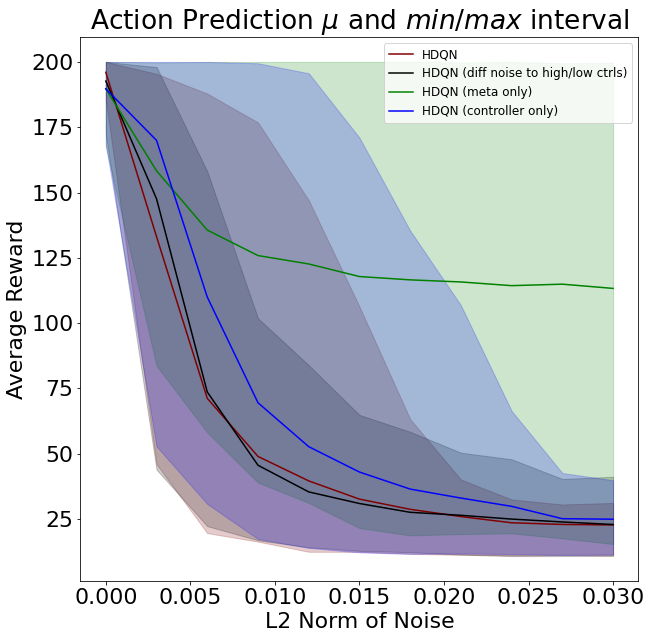

In [24]:
import json
plot_norms_minmax([\
    #(json.load(open("absolute_noise/dqn_episodes.json")), "red", "DQN"),\
    #(json.load(open("absolute_noise/td3_episodes.json")), "green", "TD3"),\
    #(json.load(open("absolute_noise/hiro_episodes.json")), "maroon", "HIRO"),\
    #(json.load(open("absolute_noise_different/hiro_episodes.json")), "black", "HIRO (diff noise to high/low ctrls)"),\
    #(json.load(open("absolute_noise_meta_only/hiro_episodes.json")), "green", "HIRO (meta only)"),\
    #(json.load(open("absolute_noise_ctrl_only/hiro_episodes.json")), "blue", "HIRO (controller only)")
    (json.load(open("absolute_noise/hdqn_episodes.json")), "maroon", "HDQN"),\
    (json.load(open("absolute_noise_different/hdqn_episodes.json")), "black", "HDQN (diff noise to high/low ctrls)"),\
    (json.load(open("absolute_noise_meta_only/hdqn_episodes.json")), "green", "HDQN (meta only)"),\
    (json.load(open("absolute_noise_ctrl_only/hdqn_episodes.json")), "blue", "HDQN (controller only)")
  ])

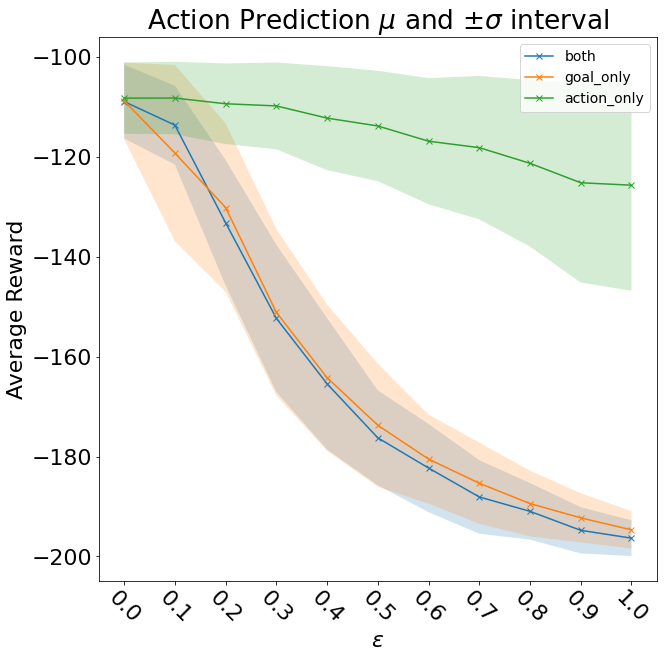

In [18]:
import json
plot_fgsm(json.load(open("car/noise_hrl/hdqn_episodes.json")))

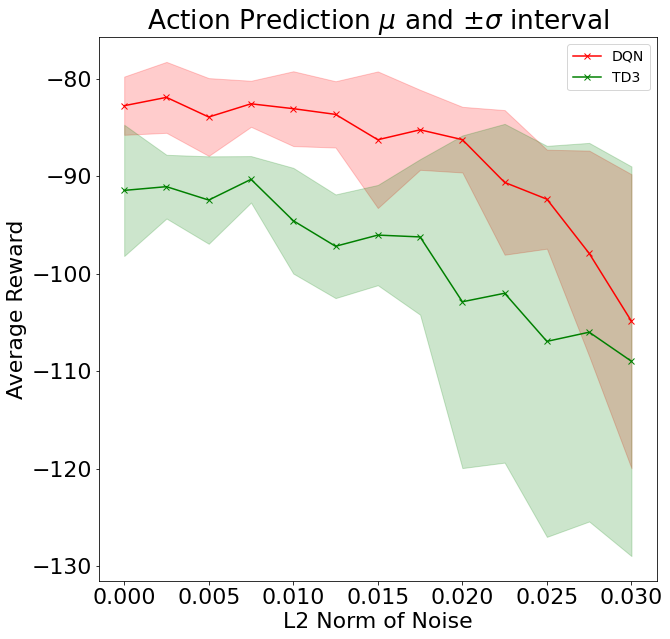

In [17]:
import json
plot_norms([\
    (json.load(open("acrobot/fgsm_targeted/dqn_episodes.json")), "red", "DQN"),\
    (json.load(open("acrobot/fgsm_untargeted/td3_episodes.json")), "green", "TD3"),\
   ])

In [11]:
hiro1 = {'both': {0.0: [93.8314225698464, 93.92023067366725, 94.53884111025145, 94.01082026783635, 93.48687742316791, 93.91282252589593, 94.3153990968144], 0.025: [92.17632844530289, 93.34774087646333, 94.64143158244802, 93.60997356164573, 93.97629040562319, 94.18258756697816, 93.1867165526663], 0.05: [94.11130100837583, 93.40901651286698, 94.62878026850436, 93.2906246022272, 94.23750783985804, 93.6182783282148, 93.03992394780971], 0.07500000000000001: [88.9313309946977, 93.49406526627003, 94.54752369540225, 93.31618631766722, 94.07826455667599, 93.59474880909913, 92.89143342909671], 0.1: [80.21431033832087, 93.30012491927877, 94.34648252483285, 93.36557139416455, 94.05981512634658, 93.79654089681667, 92.62191497739838], 0.125: [73.13969163422374, 93.37421234607258, 94.01113445761983, 93.22878623801743, 93.65822135317843, 93.2322534255169, 92.1907092516812], 0.15000000000000002: [76.26659475589946, 91.1981647940952, 93.68409850605438, 92.74118526567257, 93.46410811448725, 92.85181701382959, 91.80233296838465], 0.17500000000000002: [29.935284081260683, 71.6461792926723, 93.18060970895799, 90.0871254203134, 93.68750531095183, 91.64791451284995, 91.35006108991801], 0.2: [36.97014612885636, 83.69596438148403, 92.6666168609277, 91.96227527260909, 93.56948344200316, 90.83054956953309, 76.97401078541029], 0.225: [37.532592276477956, 68.38731739335024, 92.66529599933924, 90.81385153907908, 92.72347907723866, 85.33513098003947, 70.86720672281226], 0.25: [40.04614878834503, 70.65389130310373, 91.35153722779408, 84.62213519582953, 92.39786240378858, 89.90810026833981, 74.03517221560045], 0.275: [55.847419959602966, 67.60408149895461, 91.240601480054, 73.60070969353369, 92.05241147276007, 85.3261192148455, 47.650639897358154], 0.30000000000000004: [49.5706450185435, 56.477136106494555, 91.3806237993104, 67.53615170872241, 91.69786233908792, 67.57214214298466, 40.54388739964276]}, 'goal_only': {0.0: [93.91293568381681, 93.71137071411398, 94.55726525181552, 94.1345034901812, 93.85570590457053, 92.94218618577317, 94.02445949652284], 0.025: [92.90948573382737, 92.643012479752, 94.64914903408535, 93.6996939601111, 94.00199484401551, 94.01342374009519, 93.66163185799789], 0.05: [92.0277728563186, 93.71143274429201, 94.61013003297622, 93.72757796442156, 93.9849318798413, 93.88013129248019, 93.3068775245618], 0.07500000000000001: [84.22830292664293, 93.27938770808345, 94.5700588926662, 92.89199256650423, 94.41279540784956, 93.66456843242959, 93.01478908012628], 0.1: [78.29085011081722, 93.27710347401923, 94.39263051828435, 93.31375824914643, 94.02666321509385, 92.62769430203703, 92.17475891986534], 0.125: [78.22363723844127, 93.31216795149801, 94.23744010248986, 92.92379219576944, 94.08557378694559, 93.34142905191312, 92.24996918190962], 0.15000000000000002: [57.06771978990634, 88.9920978641728, 93.82440458747519, 92.73008734554877, 93.8133276980084, 90.12474034958093, 91.9514632396879], 0.17500000000000002: [20.86183588826175, 74.67422706535734, 93.01963688547791, 90.31651544799836, 93.69076264826818, 90.49709808032082, 91.23880342331469], 0.2: [34.22683492313501, 68.48546700908986, 92.39206846832775, 91.96431695197727, 93.53600348893717, 81.00157868266446, 78.05758495289955], 0.225: [37.75409434371617, 61.44398150617264, 91.90410575449089, 91.99268543851403, 93.1852735393575, 85.73919846395944, 73.00262166866962], 0.25: [44.55063979879333, 54.37015446259573, 91.45911549619535, 76.72364939651148, 92.58638179046869, 80.74715231170357, 68.22503789419883], 0.275: [49.94784806064659, 58.547162191373616, 91.07163307318642, 58.39663712608058, 91.93728938842786, 76.75822347502913, 49.818247896794745], 0.30000000000000004: [43.93830914389634, 49.45985017252759, 91.55340736282102, 50.30938872654204, 91.68680345591183, 71.48395980174303, 40.602299080574184]}, 'action_only': {0.0: [94.02433001678769, 94.02252251781391, 94.60227062391198, 93.97466306387031, 93.57608746456904, 94.02791979469652, 94.01021749093056], 0.025: [92.82531924057963, 93.81892122029778, 94.60007744206911, 94.24513349860328, 93.62351049704897, 93.84225988815005, 94.50056309243196], 0.05: [92.99729393387297, 93.57028796114678, 94.65420012448351, 94.02418424146907, 93.75607098579844, 93.91483792969758, 94.1349183517037], 0.07500000000000001: [94.09321850456205, 93.5187122548122, 94.60327743427784, 94.02727206436207, 93.46726591337537, 94.11281690519547, 94.10553485912953], 0.1: [93.88473909864348, 93.99484005974178, 94.58485311724137, 94.21982894669847, 93.78758359970296, 93.86089190985953, 94.06510145264888], 0.125: [93.88633997101505, 93.59909787135352, 94.65015968722619, 94.2268815940769, 93.93352863794011, 93.91606557277589, 94.20808242427852], 0.15000000000000002: [94.02703532774656, 93.48755998284149, 94.65083960771125, 93.9745825930205, 93.69210918084077, 93.84025064160843, 93.92889979335959], 0.17500000000000002: [92.83067669103451, 92.86882654934647, 94.61235728388965, 93.99599749301366, 93.80473271654074, 93.82709852430868, 94.07746505353032], 0.2: [93.65533160239669, 93.5406028191089, 94.62798080371951, 94.26085175780437, 93.56240225022799, 93.75269895518268, 94.21808451616442], 0.225: [93.90424288523792, 93.86837363320967, 94.61328694629707, 94.32223084986622, 93.7948806246513, 93.91233089696414, 93.88529469144248], 0.25: [94.11884709177758, 93.78150462189947, 94.56056817506587, 93.91469319532487, 93.894741725221, 93.90451492622815, 94.12583877279373], 0.275: [93.9909963031579, 94.02386725486544, 94.59882760976377, 94.1406063361252, 93.57655739921405, 94.07978398612622, 94.34499654726604], 0.30000000000000004: [93.92402042480325, 93.76378637670264, 94.6315655330152, 94.19889854342877, 93.5449384269182, 93.88831335562418, 93.97132838236607]}}
hiro2 = {'both': {0.0: [94.65581239573456, 92.66751295860162, 86.62242743271442], 0.025: [94.62823837986264, 92.19800348037879, 89.46198138438696], 0.05: [94.68437191896294, 91.59844014872206, 89.2322777128791], 0.07500000000000001: [94.5267458479354, 91.22928898094948, 89.43479372687081], 0.1: [94.23229243924594, 91.69083195541367, 89.01962934425872], 0.125: [93.8771682160986, 91.04619001625866, 88.81757861165994], 0.15000000000000002: [93.65306888549547, 91.0207930933348, 88.74376190816747], 0.17500000000000002: [93.18806652712509, 90.24393572768659, 88.72404389191149], 0.2: [93.1758649528023, 90.28213235114976, 88.74485048598874], 0.225: [92.6778994586106, 86.28136008164589, 88.7990495816969], 0.25: [92.28091107339243, 80.86364002838398, 88.87912624374654], 0.275: [92.13680546360224, 71.54395190299579, 88.81051879429383], 0.30000000000000004: [88.88953604688015, 56.49340783169192, -15.003525186455638]}, 'goal_only': {0.0: [94.66496683158131, 92.7167902316335, 87.62204297361313], 0.025: [94.63388995793433, 92.11713100313071, 89.35077184379263], 0.05: [94.49777597194367, 91.72862132815693, 88.71640093552273], 0.07500000000000001: [94.26435170285818, 91.09520456654693, 86.40854480272225], 0.1: [94.27916916494416, 91.21495291560237, 89.0609774890319], 0.125: [94.04924962658087, 90.97017957601784, 88.96973595792008], 0.15000000000000002: [93.70947021697769, 90.55369649671924, 88.74698389942272], 0.17500000000000002: [93.43021056655917, 90.47768604882005, 88.73432388054024], 0.2: [93.06388811112782, 87.29151766097348, 88.71945421322069], 0.225: [92.93691694777897, 86.05919770646868, 88.80936507736996], 0.25: [92.55307224472959, 76.69927967152933, 88.88920289504107], 0.275: [92.2056230618204, 65.27993592410779, 88.92128788789027], 0.30000000000000004: [91.23567962173819, 59.90810346785916, -15.061038384689844]}, 'action_only': {0.0: [94.45417464279332, 92.17920115569815, 88.85416414385594], 0.025: [94.57309196515227, 92.21591354035573, 84.61669222719864], 0.05: [94.64678434496336, 92.5627862591971, 85.54904339382469], 0.07500000000000001: [94.57969177812201, 92.61028871885895, 84.5644783487915], 0.1: [94.6223351031618, 92.41385684203847, 84.63204434460644], 0.125: [94.65996735891903, 92.47317017082327, 87.62619736015547], 0.15000000000000002: [94.63808356107651, 92.44749306492055, 88.75387634064069], 0.17500000000000002: [94.58667003140135, 92.30472894056454, 90.7241781768586], 0.2: [94.5269651007118, 92.23908565167898, 86.92506616351828], 0.225: [94.65965016048403, 92.7756064309396, 89.76020713771649], 0.25: [94.34936455380355, 92.80661530235864, 86.81803010691041], 0.275: [94.63280516822749, 92.63740874297892, 86.86167738104417], 0.30000000000000004: [94.64195680337836, 92.1948340611795, 89.60262617611345]}}

In [12]:
hiro = {}
for i in hiro1.keys():
    hiro[i] = {}
    for ii in hiro1[i].keys():
        hiro[i][ii] = list(np.concatenate([hiro1[i][ii], hiro2[i][ii]]))

In [11]:
hiro1 = {0.0: [-107.11, -103.89, -97.63, -122.91, -109.68, -169.26, -122.0, -114.59, -104.22, -98.88], 0.1: [-114.53, -111.96, -109.45, -131.7, -109.22, -162.71, -118.74, -129.95, -109.84, -103.15], 0.2: [-123.09, -129.32, -127.96, -147.81, -123.22, -164.05, -125.29, -165.79, -121.36, -137.46], 0.3: [-131.14, -149.28, -154.88, -163.73, -142.5, -175.88, -134.99, -182.37, -137.95, -161.27], 0.4: [-149.03, -165.92, -171.15, -171.23, -171.1, -179.04, -149.79, -188.98, -146.95, -173.62], 0.5: [-157.87, -179.25, -182.97, -177.33, -179.45, -180.56, -168.26, -193.65, -160.86, -177.94], 0.6: [-170.78, -189.1, -182.24, -183.86, -182.71, -184.04, -176.81, -194.55, -173.23, -176.08], 0.7: [-177.01, -195.73, -191.12, -183.77, -191.99, -191.64, -183.79, -198.19, -180.9, -184.72], 0.8: [-182.8, -197.71, -195.73, -188.63, -193.1, -190.83, -187.96, -198.44, -186.86, -185.03], 0.9: [-186.48, -200.0, -196.93, -192.09, -196.59, -194.59, -192.69, -199.65, -194.62, -182.96], 1.0: [-193.43, -200.0, -199.63, -193.75, -197.73, -198.13, -195.9, -200.0, -198.47, -189.02]}
hiro2 = {0.0: [-112.73], 0.1: [-121.77], 0.2: [-133.37], 0.3: [-153.03], 0.4: [-165.22], 0.5: [-173.38], 0.6: [-182.65], 0.7: [-188.65], 0.8: [-190.74], 0.9: [-193.01], 1.0: [-195.94]}

for i in hiro1.keys():
    #pass
    hiro1[i].pop(5)
    #hiro1[i].pop(12 - 1)
    #hiro1[i].pop(13 - 2)
    #hiro1[i].pop(16 - 3)
    #hiro1[i].pop(17 - 4)
    #hiro1[i][ii].pop(18 - 4)
    #hiro2[i][ii].pop(0)
    #hiro2[i] = np.array(hiro2[i])[[0, 1, 2, 3, 7, 8, 11]]

hiro = {}
for i in hiro1.keys():
    all_i = list(np.concatenate([hiro1[i], hiro2[i]]))
    hiro[i] = all_i

import json
json = json.dumps(hiro)
f = open("hdqn_episodes.json","w")
f.write(json)
f.close()

In [6]:
import json
eps = {0.0: [-107.11, -103.89, -97.63, -122.91, -109.68, -169.26, -122.0, -114.59, -104.22, -98.88], 0.1: [-114.53, -111.96, -109.45, -131.7, -109.22, -162.71, -118.74, -129.95, -109.84, -103.15], 0.2: [-123.09, -129.32, -127.96, -147.81, -123.22, -164.05, -125.29, -165.79, -121.36, -137.46], 0.3: [-131.14, -149.28, -154.88, -163.73, -142.5, -175.88, -134.99, -182.37, -137.95, -161.27], 0.4: [-149.03, -165.92, -171.15, -171.23, -171.1, -179.04, -149.79, -188.98, -146.95, -173.62], 0.5: [-157.87, -179.25, -182.97, -177.33, -179.45, -180.56, -168.26, -193.65, -160.86, -177.94], 0.6: [-170.78, -189.1, -182.24, -183.86, -182.71, -184.04, -176.81, -194.55, -173.23, -176.08], 0.7: [-177.01, -195.73, -191.12, -183.77, -191.99, -191.64, -183.79, -198.19, -180.9, -184.72], 0.8: [-182.8, -197.71, -195.73, -188.63, -193.1, -190.83, -187.96, -198.44, -186.86, -185.03], 0.9: [-186.48, -200.0, -196.93, -192.09, -196.59, -194.59, -192.69, -199.65, -194.62, -182.96], 1.0: [-193.43, -200.0, -199.63, -193.75, -197.73, -198.13, -195.9, -200.0, -198.47, -189.02]}

json = json.dumps(eps)
f = open("hdqn_episodes.json","w")
f.write(json)
f.close()

In [16]:
import json
# both, goal_only, action_only
eps = {
    'both': {0.0: [-103.8, -105.38, -97.45, -117.96, -109.09, -159.32, -121.18, -113.63, -104.53, -101.05], 0.1: [-115.34, -112.91, -101.9, -127.48, -108.43, -168.53, -116.31, -123.03, -106.45, -104.8], 0.2: [-120.46, -131.32, -133.54, -142.95, -122.5, -164.0, -121.09, -164.48, -124.92, -135.34], 0.3: [-133.71, -153.95, -147.46, -165.65, -147.24, -175.57, -135.29, -178.83, -135.07, -169.12], 0.4: [-143.26, -168.84, -168.84, -173.41, -168.45, -179.38, -150.8, -186.79, -147.13, -171.39], 0.5: [-161.52, -175.68, -180.4, -178.01, -179.95, -180.29, -168.06, -195.62, -163.88, -175.66], 0.6: [-168.66, -188.81, -194.24, -181.5, -184.53, -188.19, -175.51, -195.93, -171.0, -176.83], 0.7: [-175.56, -195.6, -193.21, -183.83, -191.14, -188.41, -182.66, -199.26, -181.78, -182.61], 0.8: [-183.73, -198.45, -195.04, -192.56, -190.8, -193.71, -186.83, -199.48, -190.55, -180.81], 0.9: [-189.29, -199.32, -198.65, -192.81, -197.13, -196.3, -193.87, -200.0, -195.52, -184.44], 1.0: [-195.4, -200.0, -199.32, -191.42, -198.96, -197.71, -195.73, -200.0, -197.46, -188.68]},
    'action_only': {0.0: [-107.09, -101.79, -99.4, -116.3, -107.64, -173.03, -117.58, -113.61, -102.65, -98.82], 0.1: [-108.91, -100.68, -97.23, -116.12, -108.94, -167.2, -118.48, -111.34, -106.14, -98.16], 0.2: [-105.53, -101.3, -99.28, -119.85, -108.34, -178.6, -120.88, -114.13, -105.75, -99.55], 0.3: [-105.58, -99.52, -99.77, -114.49, -110.64, -165.19, -119.29, -121.15, -105.4, -99.5], 0.4: [-105.77, -103.5, -104.13, -120.29, -111.05, -169.59, -119.53, -123.9, -106.32, -96.58], 0.5: [-108.17, -99.38, -108.7, -122.96, -110.4, -155.37, -119.72, -123.71, -108.91, -99.84], 0.6: [-108.46, -100.81, -114.82, -125.4, -112.64, -163.8, -130.56, -129.7, -108.57, -99.54], 0.7: [-110.48, -100.63, -111.54, -125.59, -113.82, -152.06, -125.69, -134.29, -111.84, -99.77], 0.8: [-114.7, -99.91, -112.8, -129.83, -116.23, -156.31, -132.71, -148.35, -110.01, -100.71], 0.9: [-115.49, -100.65, -120.04, -129.76, -115.52, -157.94, -144.22, -165.45, -112.77, -101.42], 1.0: [-113.26, -101.97, -120.05, -131.06, -116.57, -148.04, -140.08, -173.09, -113.77, -101.11]},
    'goal_only': {0.0: [-104.48, -102.36, -98.95, -118.86, -108.4, -170.61, -121.3, -113.52, -105.4, -99.13], 0.1: [-116.26, -110.54, -105.51, -125.98, -109.26, -157.41, -120.03, -168.9, -107.57, -109.83], 0.2: [-120.03, -126.51, -126.48, -139.01, -121.73, -171.13, -116.96, -176.67, -116.95, -133.48], 0.3: [-133.8, -151.87, -147.44, -163.82, -146.5, -176.87, -130.63, -188.73, -137.43, -166.14], 0.4: [-144.75, -170.55, -164.79, -172.61, -171.93, -180.86, -149.29, -192.69, -144.2, -174.46], 0.5: [-155.67, -175.37, -179.0, -179.35, -183.22, -183.82, -165.0, -198.95, -155.96, -174.8], 0.6: [-167.52, -185.62, -178.09, -185.26, -188.42, -185.88, -171.24, -199.14, -172.58, -180.45], 0.7: [-175.81, -195.03, -174.94, -187.97, -191.82, -193.75, -178.89, -199.71, -179.26, -180.96], 0.8: [-183.01, -197.04, -182.23, -192.46, -195.54, -197.45, -180.12, -200.0, -187.03, -184.59], 0.9: [-186.55, -197.98, -188.32, -192.32, -198.32, -198.13, -188.34, -199.65, -191.4, -185.25], 1.0: [-192.47, -199.63, -191.0, -195.2, -197.98, -199.28, -188.94, -200.0, -195.45, -189.97]}
}

eps2 = {
    'both': {0.0: [-115.21], 0.1: [-119.8], 0.2: [-135.39], 0.3: [-157.01], 0.4: [-175.45], 0.5: [-183.75], 0.6: [-185.93], 0.7: [-195.2], 0.8: [-191.41], 0.9: [-196.62], 1.0: [-196.37]},
    'action_only': {0.0: [-117.52], 0.1: [-116.2], 0.2: [-119.05], 0.3: [-122.62], 0.4: [-131.33], 0.5: [-136.34], 0.6: [-138.11], 0.7: [-147.88], 0.8: [-147.66], 0.9: [-146.48], 1.0: [-145.73]},
    'goal_only': {0.0: [-115.46], 0.1: [-118.46], 0.2: [-123.7], 0.3: [-144.9], 0.4: [-156.73], 0.5: [-170.03], 0.6: [-176.67], 0.7: [-189.03], 0.8: [-192.07], 0.9: [-194.54], 1.0: [-196.12]}
}

for i in eps.keys():
    for ii in eps[i].keys():
        eps[i][ii].pop(5)

eps0 = {}
for i in eps.keys():
    eps0[i] = {}
    for ii in eps[i].keys():
        all_i = list(np.concatenate([eps[i][ii], eps2[i][ii]]))
        eps0[i][ii] = all_i

json = json.dumps(eps0)
f = open("hdqn_episodes.json","w")
f.write(json)
f.close()

***
Things for making gifs:

In [ ]:
# tricks to make rendering work in Colab
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
# goal: 0 to 1; action: 0 to 1
def append_action_goal_to_screen(img, goal, action):
    img = np.array(img[:,::-1])
    max_width = 100
    height = 50

    # omit these two lines for HIRO
    goal = goal * 2 - 1
    action = action * 2 - 1

    if goal < 0:
        cv2.rectangle(img, (int(max_width + goal * max_width), 0), (max_width, height), (255, 0, 0), -1) # goal
    else:
        cv2.rectangle(img, (max_width, 0), (int(max_width + goal * max_width), height), (255, 0, 0), -1) # goal
    if action < 0:
        cv2.rectangle(img, (int(max_width + action * max_width), height), (max_width, 2 * height), (0, 0, 255), -1) # action
    else:
        cv2.rectangle(img, (max_width, height), (int(max_width + action * max_width), 2 * height), (0, 0, 255), -1) # action
    return img

In [ ]:
def render_single_episode(hdqnAgent): # HDQN
    hdqnAgent.eval()
    hdqnAgent.meta_controller.eval()
    hdqnAgent.controller.eval()

    max_episode_length = 200
    num_episodes = 100

    frames = []

    overall_reward = 0
    observation = env.reset()

    state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

    episode_steps = 0
    done = False
    while not done:
        # select a goal
        goal = hdqnAgent.select_goal(state)
        goal_i = goal.item()
        encoded_goal = torch.from_numpy(one_hot(2, goal)).float().to(device)

        goal_done = False
        while not done and not goal_done:
            joint_goal_state = torch.cat([encoded_goal, state], axis=1)

            action = hdqnAgent.select_action(joint_goal_state)
            action_i = action.item()

            frames.append(append_action_goal_to_screen(env.render(mode="rgb_array"), goal_i, action_i))

            observation, reward, done, _ = env.step(action_i)

            overall_reward += reward

            if max_episode_length and episode_steps >= max_episode_length - 1:
                done = True
            episode_steps += 1

            goal_done = (goal_i == action_i)

            state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
    return frames, overall_reward

In [ ]:
def render_single_episode(agent): #HIRO
    agent.eval()
    agent.meta_controller.eval()
    agent.controller.eval()

    max_episode_length = 200
    agent.meta_controller.is_training = False
    agent.controller.is_training = False

    num_episodes = 1

    frames = []

    overall_reward = 0
    observation = env.reset()
    # set a large starting angle
    env.state[2] = -env.observation_space.high[2] / 2.0
    observation = np.array(env.state)

    state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

    episode_steps = 0
    done = False
    while not done:
        # select a goal
        goal = agent.select_goal(state, False)

        goal_done = False
        while not done and not goal_done:
            action = agent.select_action(state, goal, False)

            frames.append(append_action_goal_to_screen(env.render(mode="rgb_array"), goal, action))

            observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())

            next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
            next_goal = agent.h(state, goal, next_state)
                              
            overall_reward += reward

            if max_episode_length and episode_steps >= max_episode_length - 1:
                done = True
            episode_steps += 1

            goal_done = agent.goal_reached(state, goal, next_state)

            state = next_state
            goal = next_goal
    return frames, overall_reward

In [ ]:
frames, overall_reward = render_single_episode(agent)
print(overall_reward)

import pickle
with open('frames.pkl', 'wb') as f:
    pickle.dump(frames, f)

In [ ]:
with open('frames.pkl', 'rb') as f:
    frames = pickle.load(f)
with open('openai_gym.gif', 'wb') as f:
    frames = list(map(lambda x: Image.fromarray(x), frames))
    im = Image.new('RGB', frames[0].size)
    im.save(f, save_all=True, append_images=frames)